# Data Modeling Assignment
***

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import graphviz
import random
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Data Reading and Extracting
***

In [2]:
# Reading Dataset
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()

ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns

In [3]:
# Standardizing Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ground_water_df[numeric])

ground_water_df[numeric] = scaled_data

ground_water_df[numeric].info()

<class 'pandas.core.frame.DataFrame'>
Index: 817 entries, 0 to 1023
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sno       817 non-null    float64
 1   lat_gis   817 non-null    float64
 2   long_gis  817 non-null    float64
 3   RL_GIS    817 non-null    float64
 4   pH        817 non-null    float64
 5   E.C       817 non-null    float64
 6   TDS       817 non-null    float64
 7   CO3       817 non-null    float64
 8   HCO3      817 non-null    float64
 9   Cl        817 non-null    float64
 10  F         817 non-null    float64
 11  NO3       817 non-null    float64
 12  SO4       817 non-null    float64
 13  Na        817 non-null    float64
 14  K         817 non-null    float64
 15  Ca        817 non-null    float64
 16  Mg        817 non-null    float64
 17  T.H       817 non-null    float64
 18  SAR       817 non-null    float64
 19  RSC       817 non-null    float64
dtypes: float64(20)
memory usage: 134.0 K

In [4]:
# Extracting Chosen Feature to Dataframe
chosen = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'mandal', 'village', 'Classification.1']
working_gw_df = ground_water_df[chosen]
working_gw_df = working_gw_df.replace('MR', 'U.S.')

# One-hot encode 'mandal' and 'village' columns separately
mandal_dummies = pd.get_dummies(working_gw_df['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(working_gw_df['village'], prefix='village')

# Concatenate the encoded columns with the original DataFrame
working_gw_df_encoded = pd.concat([working_gw_df.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)
working_gw_df_encoded = working_gw_df_encoded.replace('MR', 'U.S.')

# Display the modified DataFrame
working_gw_df_encoded.head()

,RSC,SAR,Na,E.C,TDS,HCO3,pH,Classification.1,mandal_Abdullapurmet,mandal_Achampet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-0.397517,-0.269850,-0.217122,-0.058802,-0.057868,-0.167582,0.554699,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.381974,-0.725000,-0.919357,-1.482665,-1.482833,-1.650267,0.951455,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.101503,0.308313,0.109269,-0.239994,-0.239528,0.690815,0.438006,U.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.441934,0.021282,-0.029200,-0.114670,-0.114489,0.300635,0.484683,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.022209,-0.282152,-0.227013,0.009145,0.008190,0.378671,0.718069,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False


# Random Forest Algorithm
***

## 1. Random Forest with All Chosen Features

In [5]:
# Splitting Data
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [6]:
# Random Forest
rf = RandomForestClassifier(random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [7]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.963302752293578


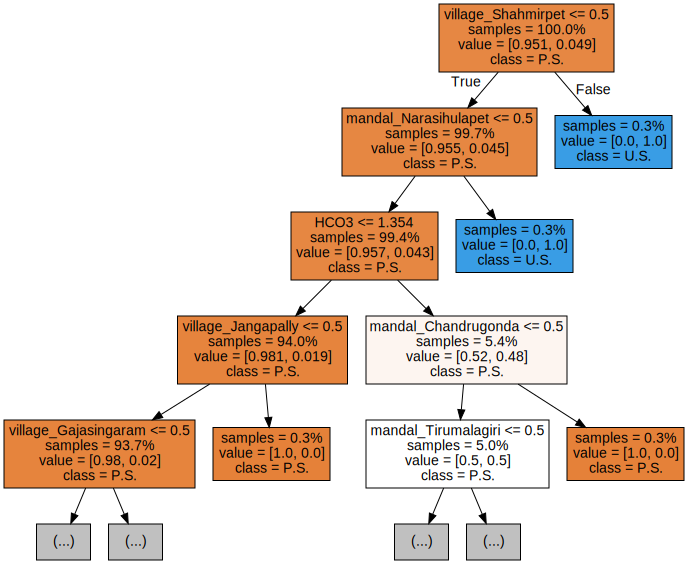

In [8]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

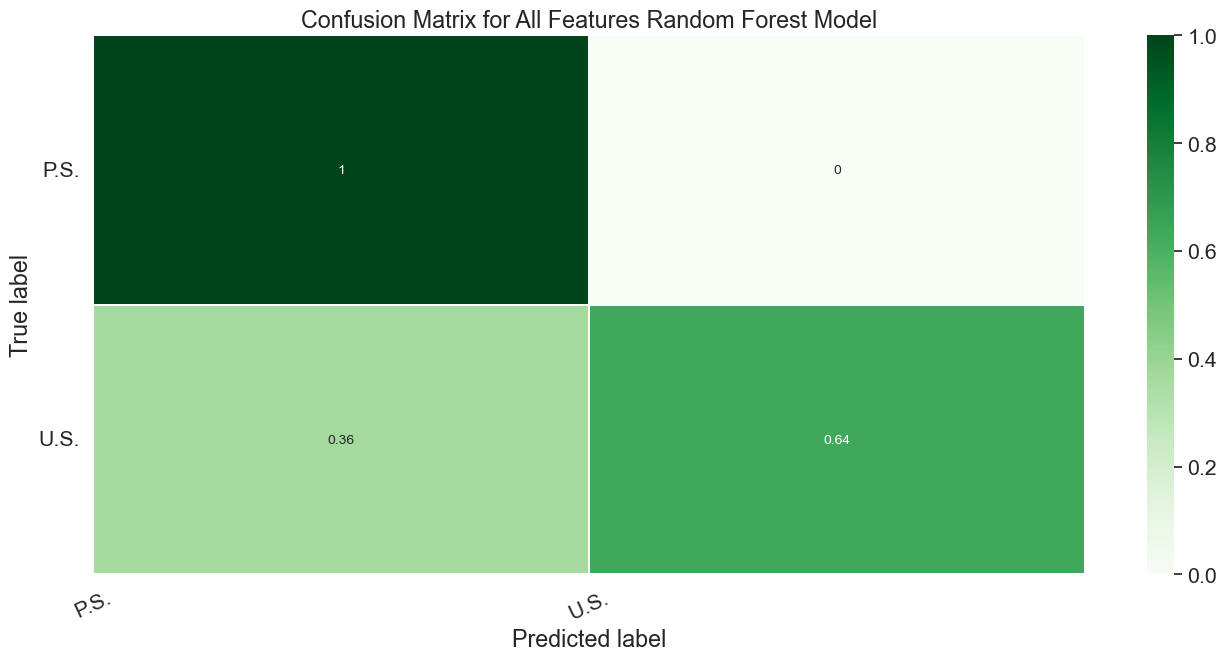

In [9]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model')
plt.show()

In [10]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.96      1.00      0.98       294
        U.S.       1.00      0.64      0.78        33

    accuracy                           0.96       327
   macro avg       0.98      0.82      0.88       327
weighted avg       0.96      0.96      0.96       327



### 2. Cross Validating Best Hyperparameters all Features

In [11]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000205D38BDBD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000205D38ABD50>})

In [12]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 444}


In [13]:
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [14]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9480122324159022


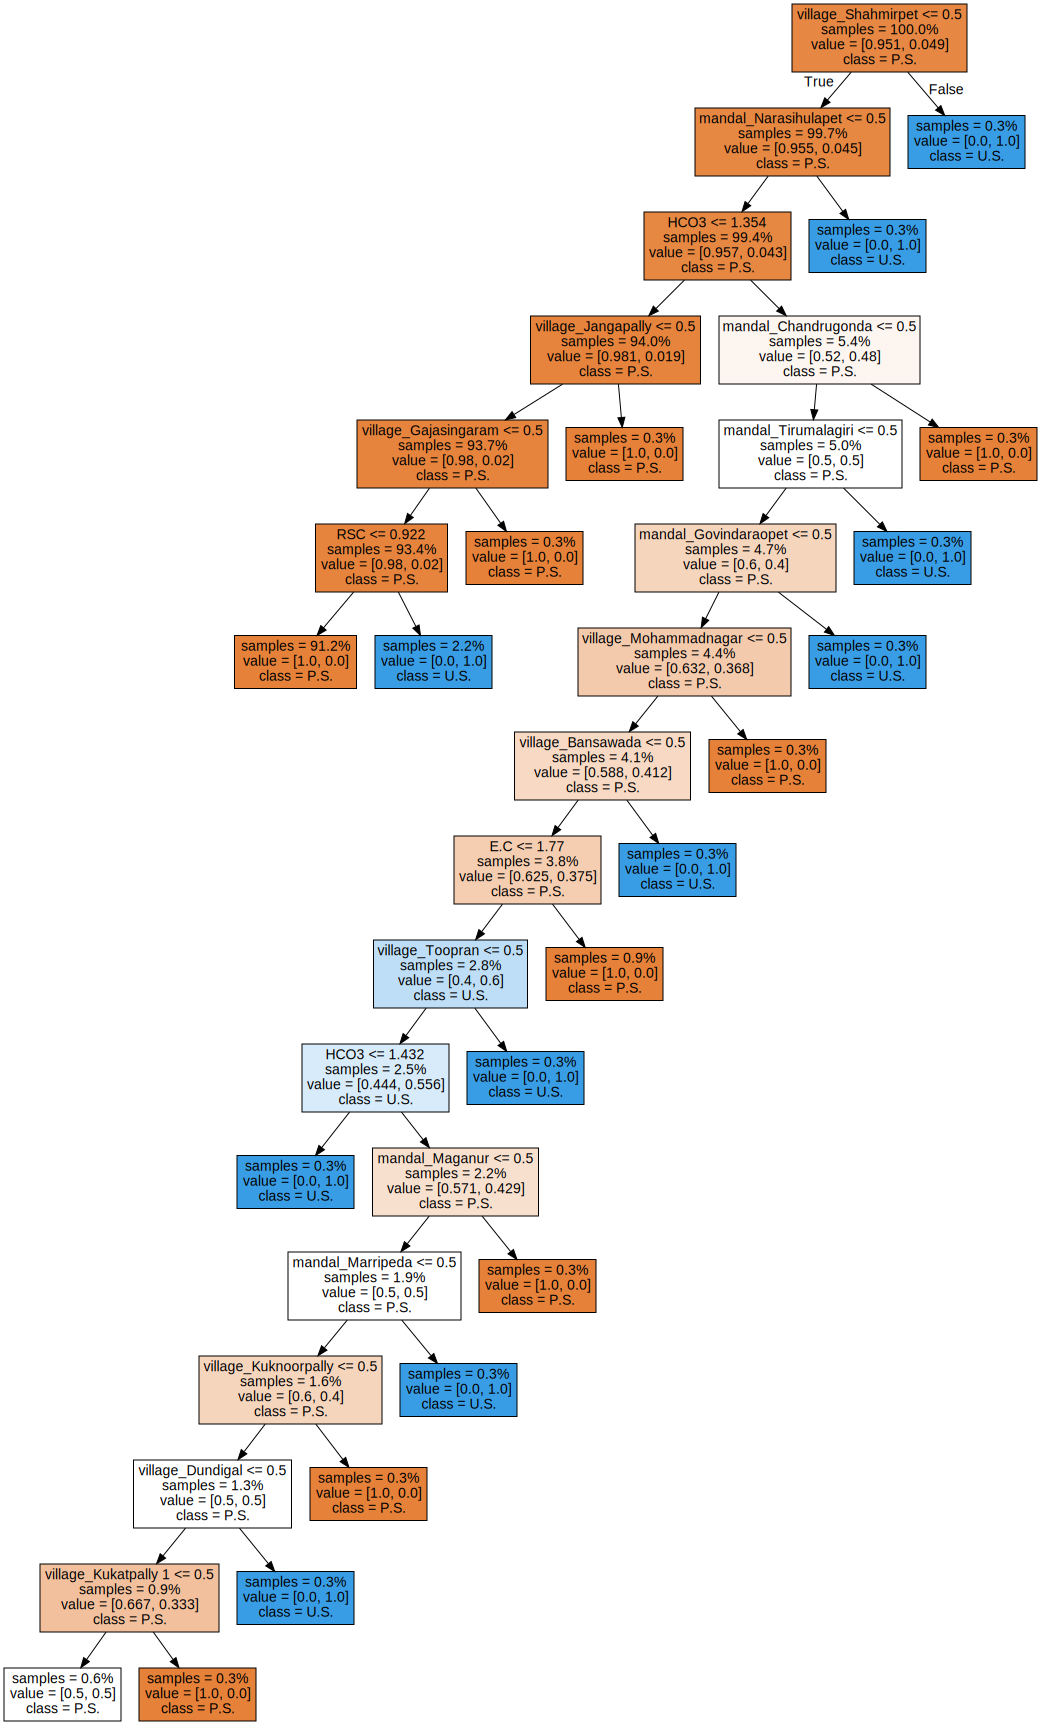

In [15]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True,  class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

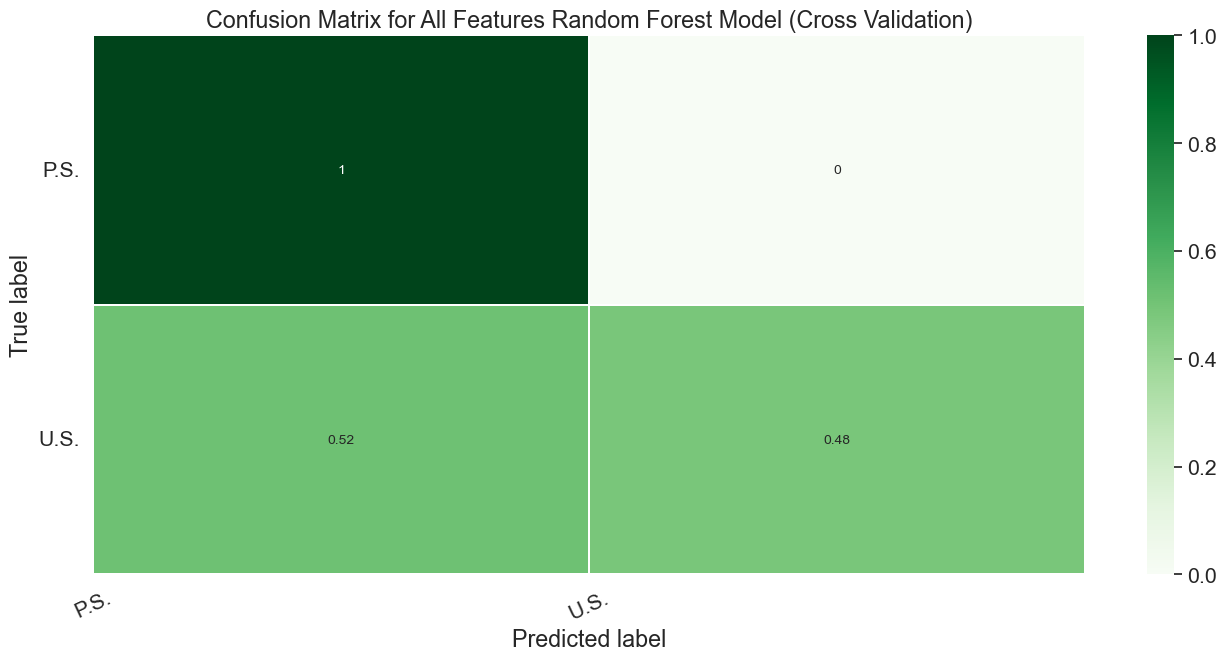

In [16]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (Cross Validation)')
plt.show()

In [17]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.95      1.00      0.97       294
        U.S.       1.00      0.48      0.65        33

    accuracy                           0.95       327
   macro avg       0.97      0.74      0.81       327
weighted avg       0.95      0.95      0.94       327



### 3. Out of Bag Evaluation All Features

Accuracy: 0.9602446483180428


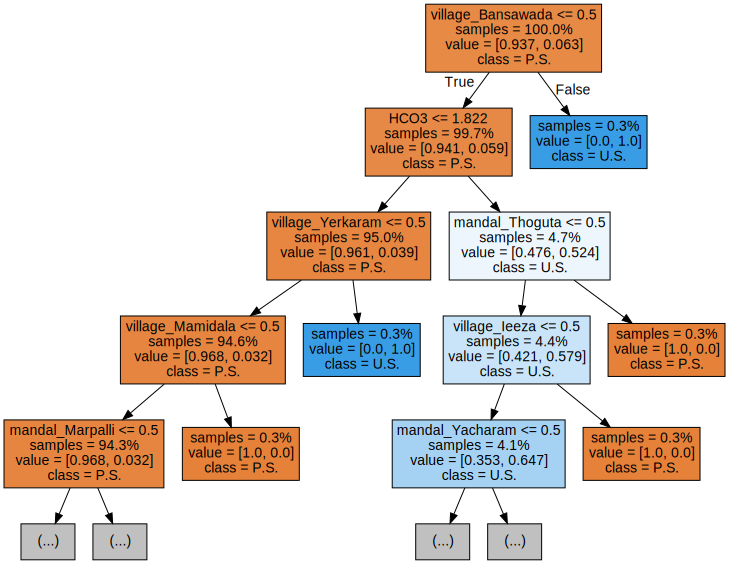

In [18]:
random.seed(10)
# Splitting Data
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

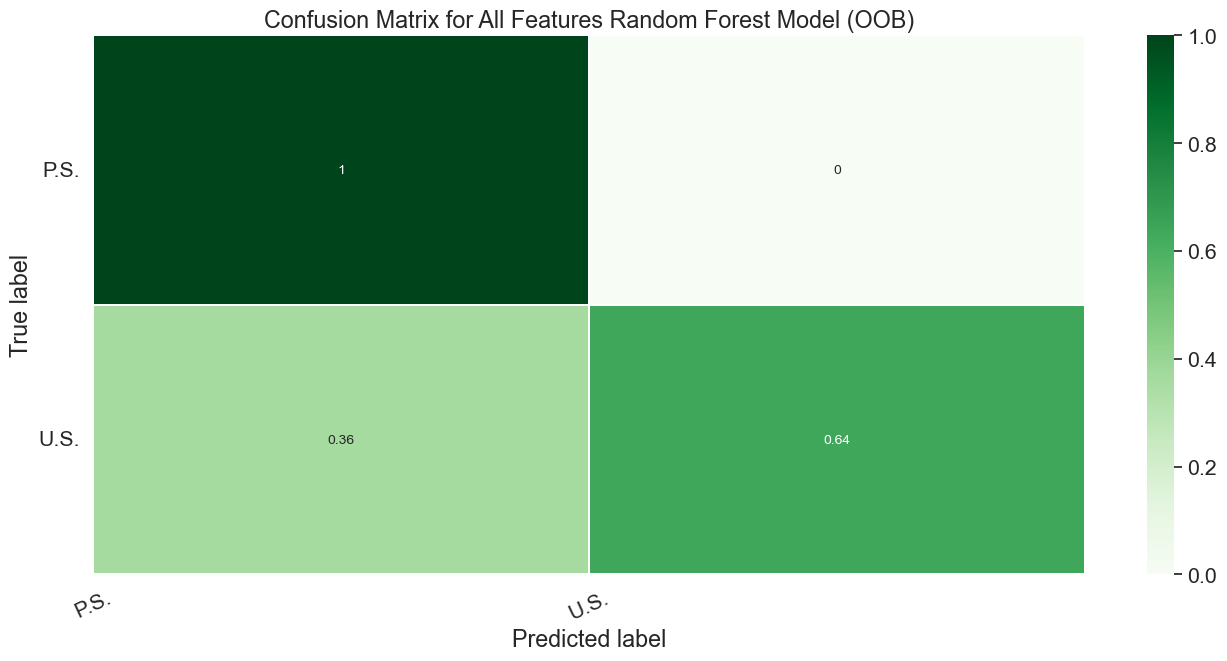

In [19]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (OOB)')
plt.show()

In [20]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.96      1.00      0.98       291
        U.S.       1.00      0.64      0.78        36

    accuracy                           0.96       327
   macro avg       0.98      0.82      0.88       327
weighted avg       0.96      0.96      0.96       327



### 4. Out of Bag Evaluation Cross Validated All Features

Best hyperparameters: {'max_depth': 17, 'n_estimators': 478}
Accuracy: 0.944954128440367


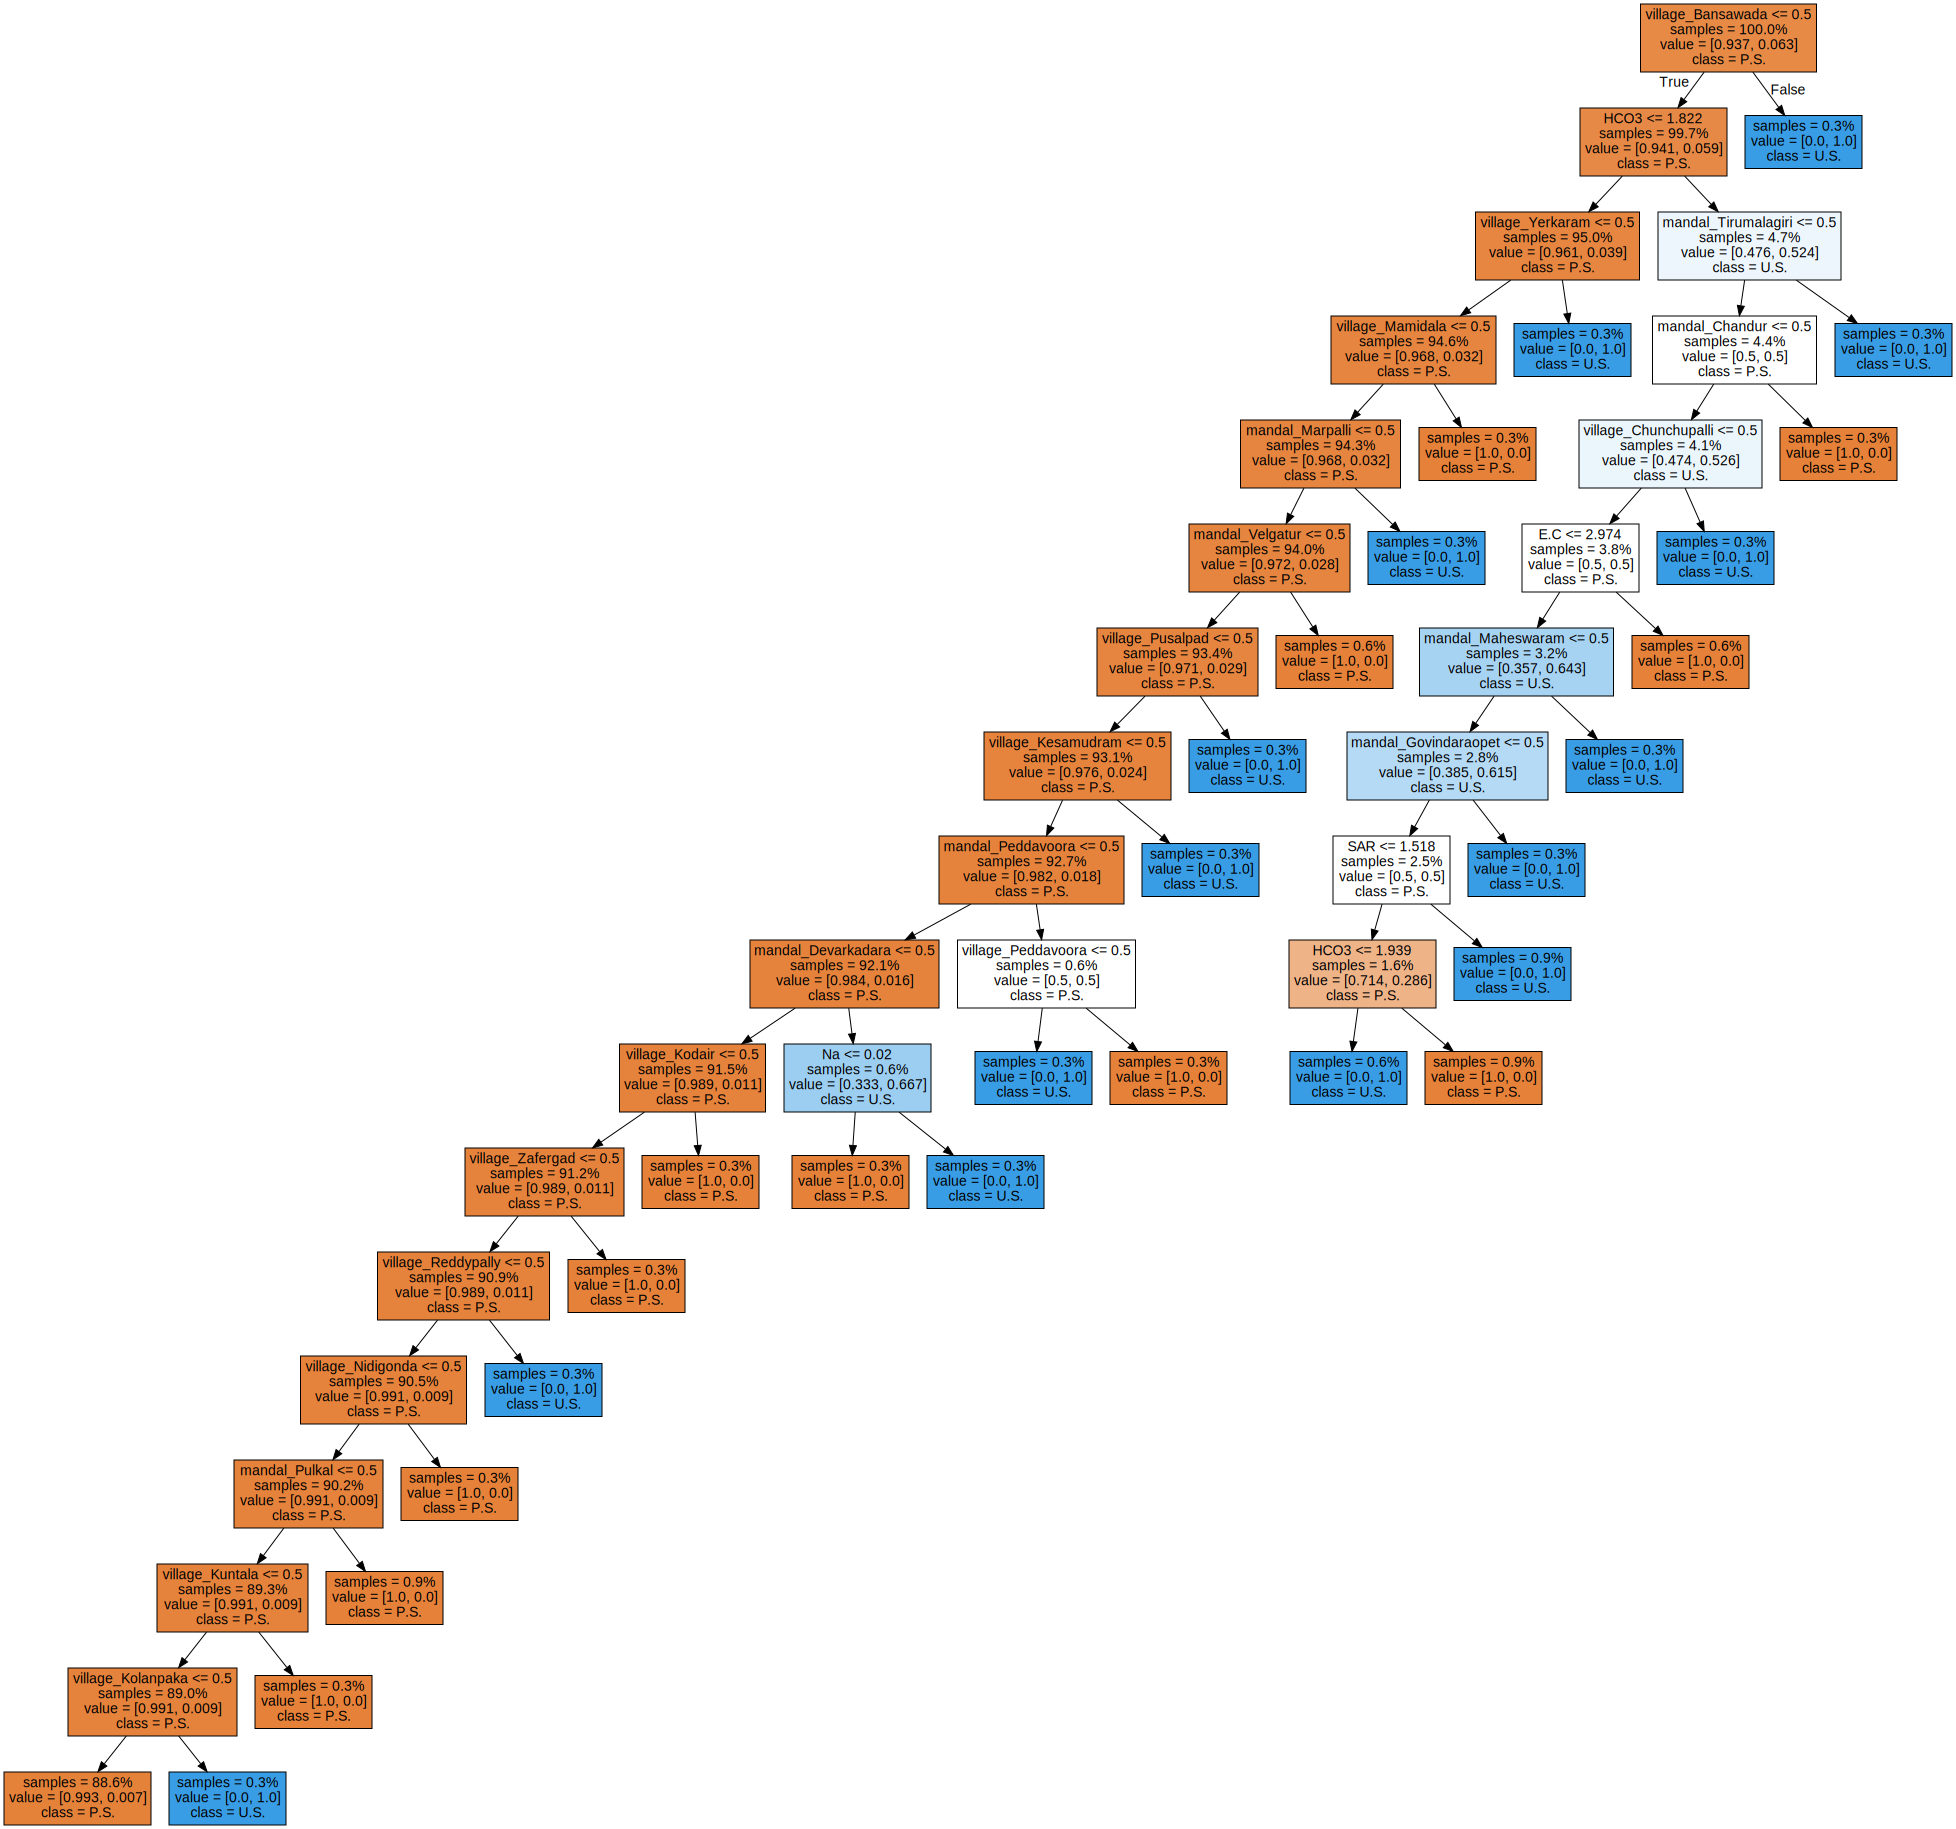

In [21]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

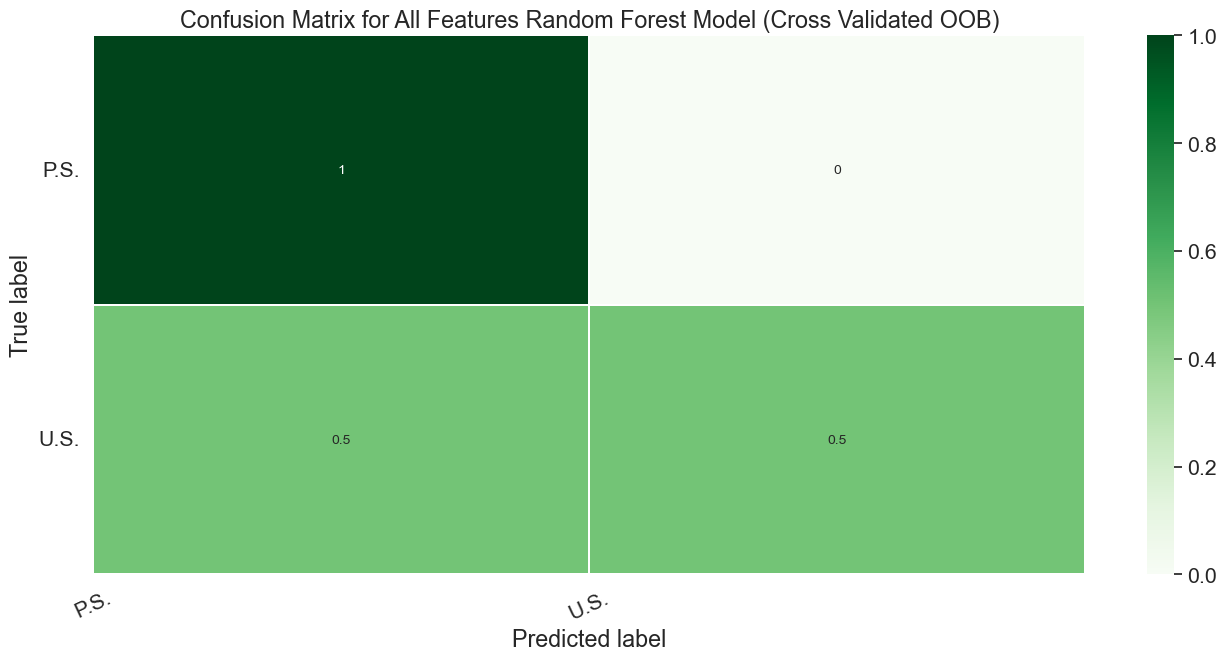

In [22]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (Cross Validated OOB)')
plt.show()

In [23]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.94      1.00      0.97       291
        U.S.       1.00      0.50      0.67        36

    accuracy                           0.94       327
   macro avg       0.97      0.75      0.82       327
weighted avg       0.95      0.94      0.94       327



******

## 1. Random Forest with only Numeric Features

Accuracy: 1.0


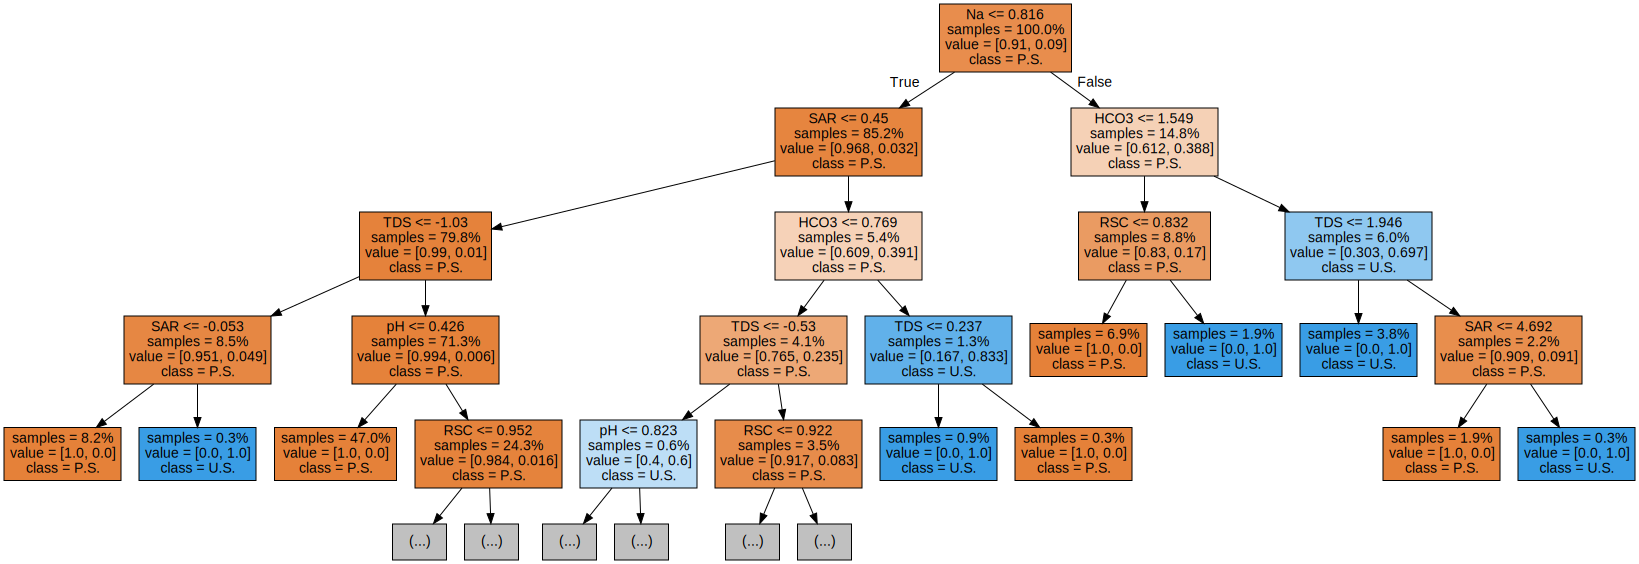

In [24]:
random.seed(10)
# Splitting Data
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

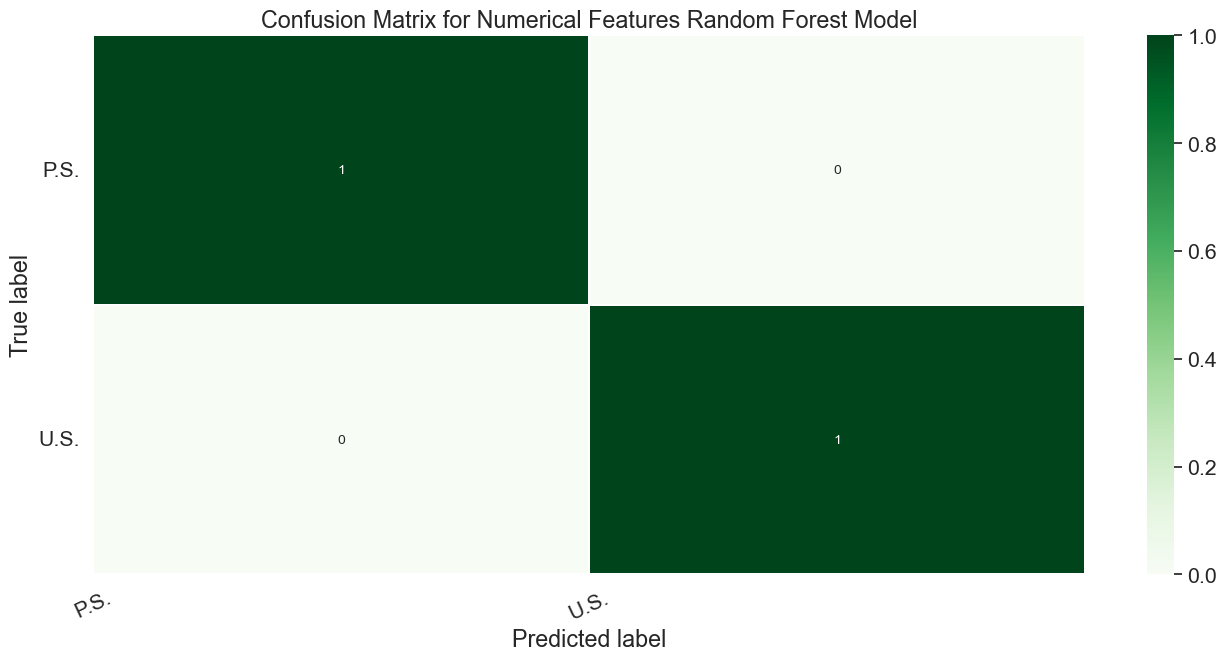

In [25]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model')
plt.show()

In [26]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       303
        U.S.       1.00      1.00      1.00        24

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327



### 2. Cross Validating Best Hyperparameters Numeric Features

In [27]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 199}


Accuracy: 1.0


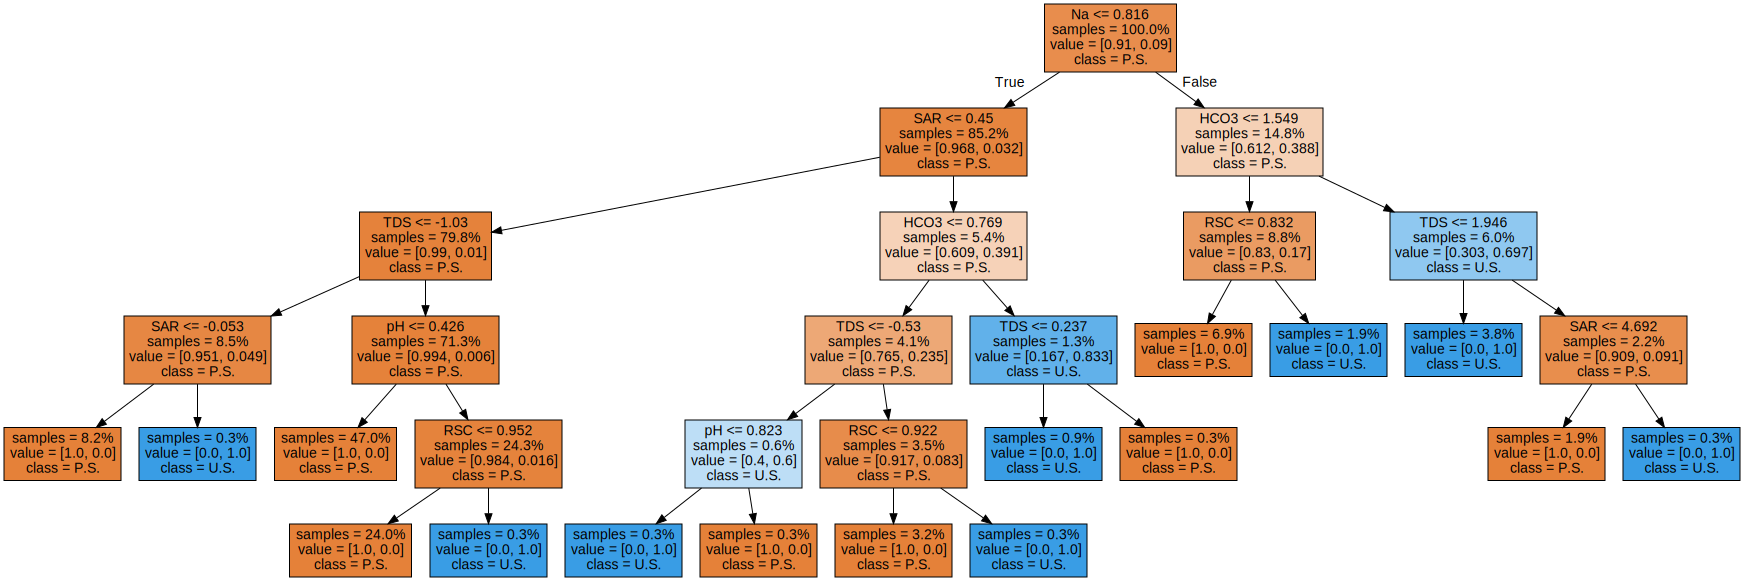

In [28]:
random.seed(10)
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

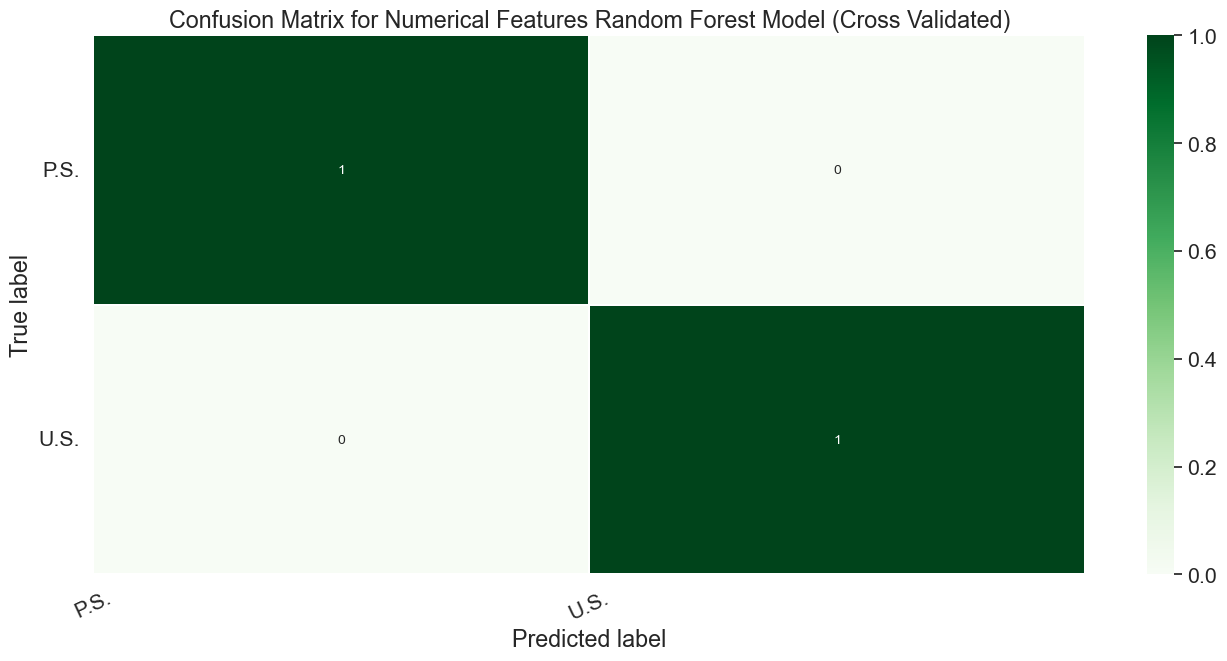

In [29]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (Cross Validated)')
plt.show()

In [30]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       303
        U.S.       1.00      1.00      1.00        24

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327



### 3. Out of Bag Evaluation Numeric Features

Accuracy: 1.0


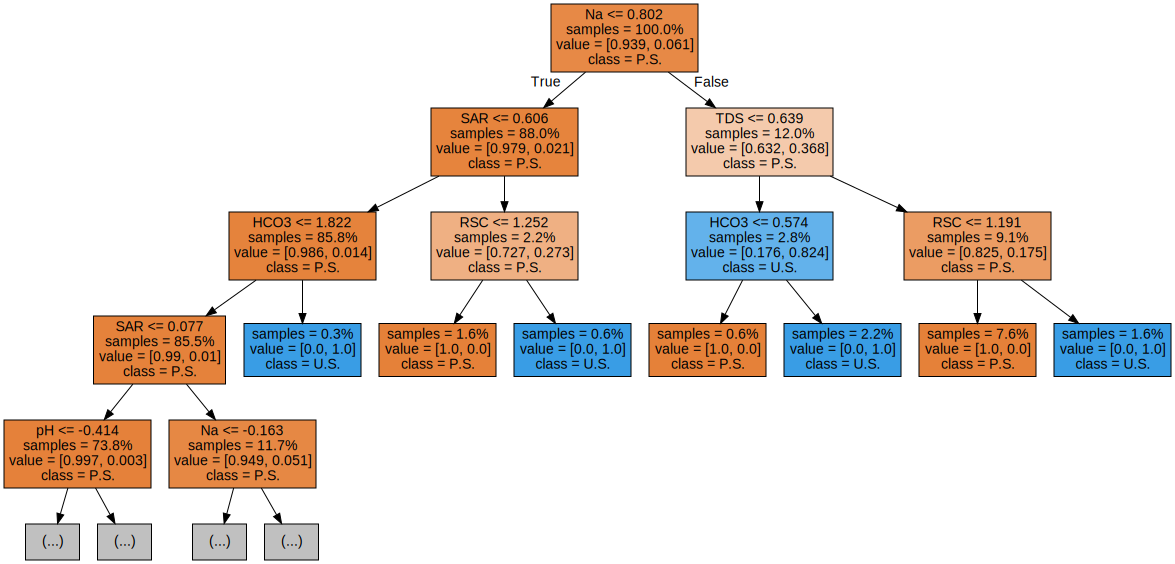

In [31]:
random.seed(10)
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

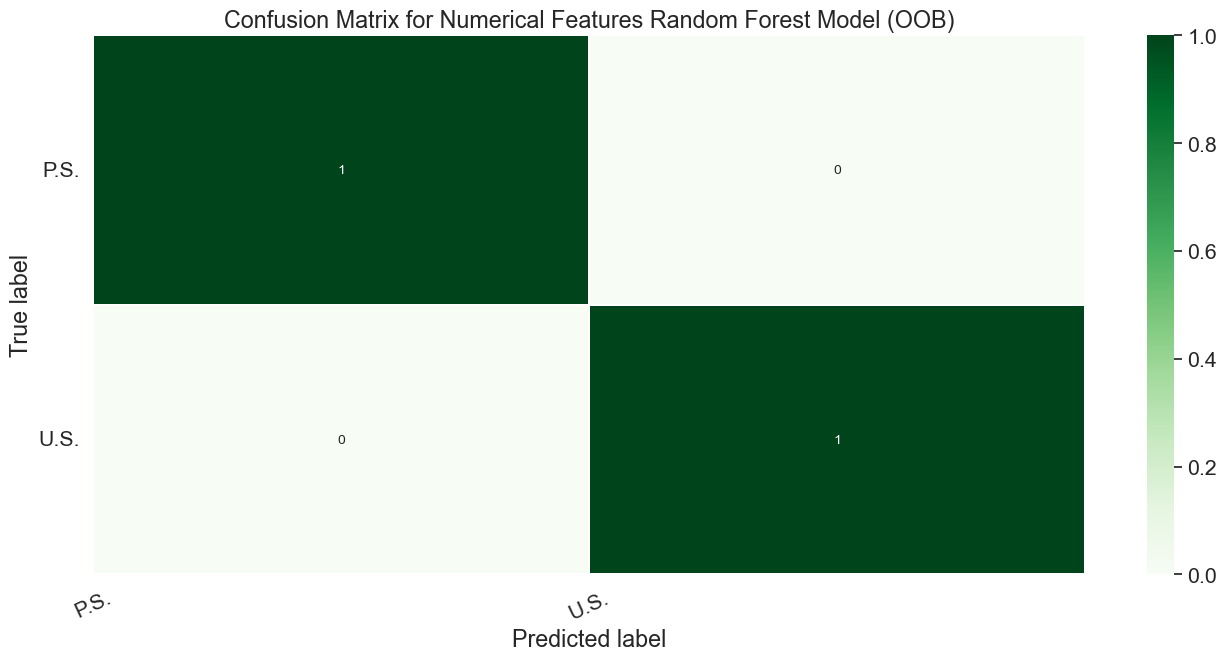

In [32]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (OOB)')
plt.show()

In [33]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       301
        U.S.       1.00      1.00      1.00        26

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327



### 4. Out of Bag Evaluation Cross Validated Numeric Features

Best hyperparameters: {'max_depth': 6, 'n_estimators': 457}
Accuracy: 1.0


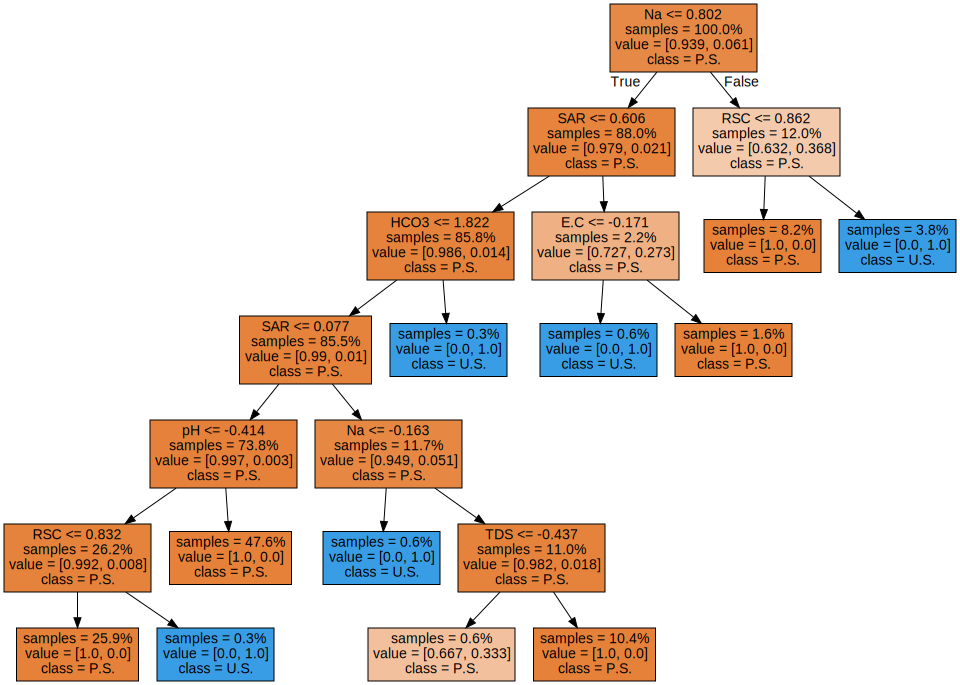

In [34]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

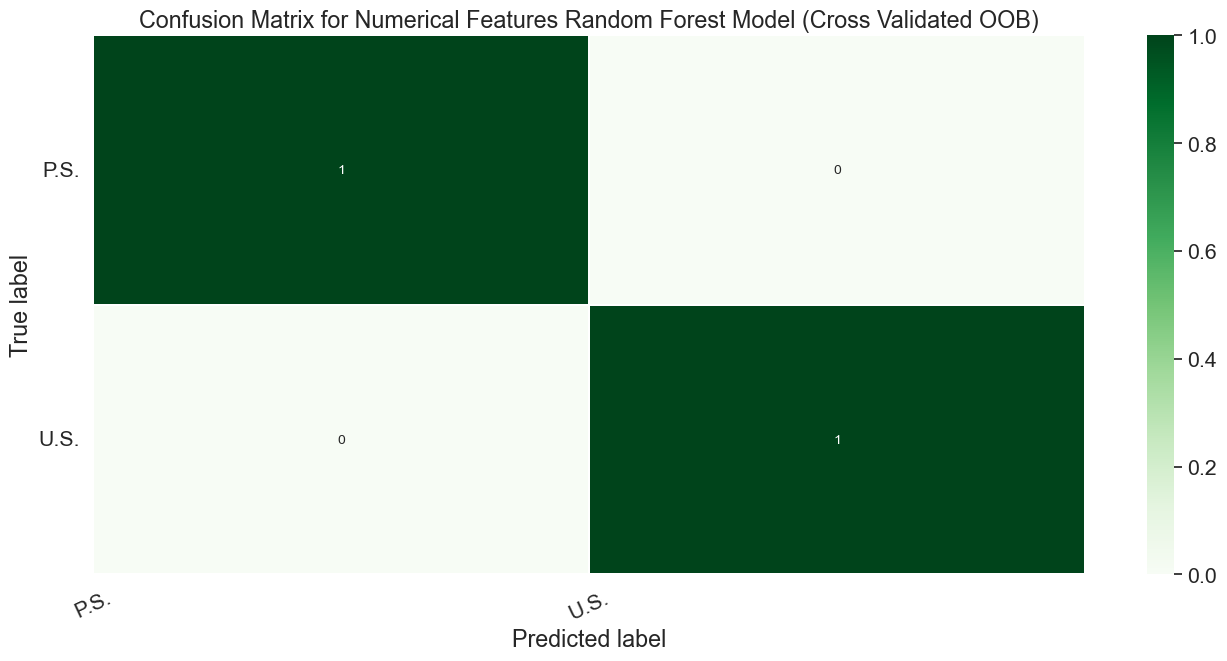

In [35]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (Cross Validated OOB)')
plt.show()

In [36]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       301
        U.S.       1.00      1.00      1.00        26

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327

